In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import time
import sys
import os

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/lish-moa/train_features.csv')
test_df = pd.read_csv('/content/drive/MyDrive/lish-moa/test_features.csv')
targetns = pd.read_csv('/content/drive/MyDrive/lish-moa/train_targets_nonscored.csv')
train_target_df = pd.read_csv('/content/drive/MyDrive/lish-moa/train_targets_scored.csv')
sub = pd.read_csv('/content/drive/MyDrive/lish-moa/sample_submission.csv')

In [4]:
target_cols = train_target_df.columns[1:]
N_TARGETS = len(target_cols)
print(train_df.shape)

(23814, 876)


In [5]:
cells = [col for col in train_df.columns if col.startswith('c-')]
genes = [col for col in train_df.columns if col.startswith('g-')]

In [6]:
# For g- features
n_comp = 50
data = pd.concat([pd.DataFrame(train_df[genes]), pd.DataFrame(test_df[genes])])
data2 = (PCA(n_components = 50, random_state = 100).fit_transform(data[genes]))
train2 = data2[:train_df.shape[0]]
test2 = data2[-test_df.shape[0]:]

train2 = pd.DataFrame(train2, columns = [f'pca_G-{i}' for i in range(50)])
test2 = pd.DataFrame(test2, columns = [f'pca_G-{i}' for i in range(50)])

train_df = pd.concat((train_df, train2), axis = 1)
test_df = pd.concat((test_df, test2), axis = 1)

In [7]:
# For c- features
data = pd.concat([pd.DataFrame(train_df[cells]), pd.DataFrame(test_df[cells])])
data2 = (PCA(n_components = 15, random_state = 100).fit_transform(data[cells]))
train2 = data2[:train_df.shape[0]]
test2 = data2[-test_df.shape[0]:]

train2 = pd.DataFrame(train2, columns = [f'pca_C-{i}' for i in range(15)])
test2 = pd.DataFrame(test2, columns = [f'pca_C-{i}' for i in range(15)])
train_df = pd.concat((train_df, train2), axis = 1)
test_df = pd.concat((test_df, test2), axis = 1)
# train_df

In [8]:
from sklearn.feature_selection import VarianceThreshold

train_copy = train_df
var_thresh = VarianceThreshold(0.8)
data = train_df.append(test_df)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])
data_transformed.shape

(27796, 868)

In [10]:
train_df_trans = data_transformed[ : train_df.shape[0]]
test_df_trans = data_transformed[-test_df.shape[0] : ]

train_df = pd.DataFrame(train_df[['sig_id', 'cp_type', 'cp_time', 'cp_dose']].values.reshape(-1, 4), columns = ['sig_id', 'cp_type', 'cp_time', 'cp_dose'])
# train_df.head
train_df = pd.concat([train_df, pd.DataFrame(train_df_trans)], axis = 1)


test_df = pd.DataFrame(test_df[['sig_id', 'cp_type', 'cp_time', 'cp_dose']].values.reshape(-1, 4), columns = ['sig_id', 'cp_type', 'cp_time', 'cp_dose'])
# train_df.head
test_df = pd.concat([test_df, pd.DataFrame(test_df_trans)], axis = 1)
# train_df.head

In [11]:
search_row = dict(train_copy.iloc[0, 4:])
col_rela = {}
for i in np.arange(0, 868):
  for k, v in search_row.items():
    if train_df[i][0] == v.all():
      col_rela[i] = k
train_df = train_df.rename(columns = col_rela)
test_df = test_df.rename(columns = col_rela)


In [12]:
SEED = 1925
EPOCHS = 25
BATCH_SIZE = 128
FOLDS = 5
REPEATS = 5
LR = 0.0005
N_TARGETS = len(target_cols)

In [13]:
def seed_everything(seed):
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  tf.random.set_seed(seed)

In [14]:
def multi_log_loss(y_true, y_pred):
  losses = []
  for col in y_true.columns:
    losses.append(log_loss(y_true.loc[:, col], y_pred.loc[:, col]))
  return np.mean(losses)

In [15]:
def preprocess_df(data):
  # data['cp_type'] = (data['cp_type'] == 'trt_cp').astype(int)
  # data['cp_dose'] = (data['cp_dose'] == 'D2').astype(int)
  data.drop(['cp_type'], axis = 1, inplace = True)
  data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1':0, 'D2':1})
  data.loc[:, 'cp_time'] = data.loc[:, 'cp_time'].map({24:0, 48:1, 72:2})
  return data

In [16]:
x_train = preprocess_df(train_df.drop(columns = "sig_id"))
x_test = preprocess_df(test_df.drop(columns = "sig_id"))
y_train = train_target_df.drop(columns = "sig_id")
N_FEATURES = x_train.shape[1]

In [17]:
x_train = x_train.astype({'cp_time':int})
x_test = x_test.astype({'cp_time':int})
# x_train

In [18]:
def create_model():
  # model = tf.keras.Sequential([tf.keras.layers.Input(N_FEATURES), tf.keras.layers.BatchNormalization(),
  #                              tf.keras.layers.Dropout(0.2), 
  #                              tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation = "relu")),
  #                              tf.keras.layers.BatchNormalization(), tf.keras.layers.Dropout(0.5), 
  #                              tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation = "relu")),
  #                              tf.keras.layers.BatchNormalization(), tf.keras.layers.Dropout(0.5),
  #                              tfa.layers.WeightNormalization(tf.keras.layers.Dense(N_TARGETS, activation = "sigmoid"))])
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(N_FEATURES))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation = "relu")))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation = "relu")))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tfa.layers.WeightNormalization(tf.keras.layers.Dense(N_TARGETS, activation = "sigmoid")))
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR), loss = 'binary_crossentropy', metrics = ["accuracy"])
  return model

In [19]:
def build_train(resume_models = None, repeat_number = 0, folds = 5, skip_folds = 0):
  models = []
  oof_preds = y_train.copy()
  kfold = KFold(n_splits = folds, shuffle = True)
  for fold, (train_ind, val_ind) in enumerate(kfold.split(x_train)):
    print(f'Training fold {fold + 1}')
    fold = fold + 1
    cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                          factor = 0.4, patience = 2, 
                                                          verbose = 1, min_delta = 0.0001, 
                                                          mode = 'auto')
    checkpoint_path = f'repeat:{repeat_number}_Fold:{fold}.hdf5'
    cb_checkpt = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor = 'val_loss', 
                                                    verbose = 0,
                                                    save_best_only = True, save_weights_only = True, 
                                                    mode = 'min')
    model = create_model()
    training_history = model.fit(x_train.values[train_ind], y_train.values[train_ind], 
              validation_data = (x_train.values[val_ind], y_train.values[val_ind]),
              callbacks = [cb_lr_schedule, cb_checkpt], epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 2)
    model.load_weights(checkpoint_path)
    oof_preds.loc[val_ind, :] = model.predict(x_train.values[val_ind])
    models.append(model)
    print('train:')
    print(list(zip(model.metrics_names, model.evaluate(x_train.values[train_ind], y_train.values[train_ind], verbose = 0, batch_size = 32))))
    print('val:')
    print(list(zip(model.metrics_names, model.evaluate(x_train.values[train_ind], y_train.values[train_ind], verbose = 0, batch_size = 32))))
    return models, oof_preds, training_history
  

In [20]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 870)               3480      
_________________________________________________________________
dropout (Dropout)            (None, 870)               0         
_________________________________________________________________
weight_normalization (Weight (None, 2048)              3569665   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
weight_normalization_1 (Weig (None, 2048)              8394753   
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8

In [22]:
models = []
oof_preds = []
# seed_everything(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
# SEED_ARRAY = [0, 1, 2, 3, 4]
for i in range(REPEATS):
  m, oof, history = build_train(repeat_number = i, folds = FOLDS)
  models = models + m
  oof_preds.append(oof)

Training fold 1
Epoch 1/25
149/149 - 2s - loss: 0.5672 - accuracy: 0.0261 - val_loss: 0.2215 - val_accuracy: 0.0516
Epoch 2/25
149/149 - 2s - loss: 0.1005 - accuracy: 0.0499 - val_loss: 0.0428 - val_accuracy: 0.0896
Epoch 3/25
149/149 - 2s - loss: 0.0329 - accuracy: 0.0706 - val_loss: 0.0248 - val_accuracy: 0.0873
Epoch 4/25
149/149 - 2s - loss: 0.0239 - accuracy: 0.0796 - val_loss: 0.0212 - val_accuracy: 0.0920
Epoch 5/25
149/149 - 2s - loss: 0.0208 - accuracy: 0.0885 - val_loss: 0.0192 - val_accuracy: 0.0792
Epoch 6/25
149/149 - 2s - loss: 0.0198 - accuracy: 0.0902 - val_loss: 0.0184 - val_accuracy: 0.0861
Epoch 7/25
149/149 - 2s - loss: 0.0186 - accuracy: 0.0964 - val_loss: 0.0179 - val_accuracy: 0.0907
Epoch 8/25
149/149 - 2s - loss: 0.0181 - accuracy: 0.1003 - val_loss: 0.0173 - val_accuracy: 0.0951
Epoch 9/25
149/149 - 2s - loss: 0.0176 - accuracy: 0.1055 - val_loss: 0.0171 - val_accuracy: 0.0997
Epoch 10/25
149/149 - 2s - loss: 0.0172 - accuracy: 0.1090 - val_loss: 0.0167 - val_

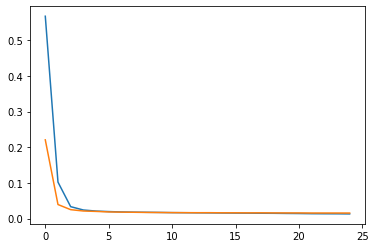

In [31]:
history.history['loss']
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

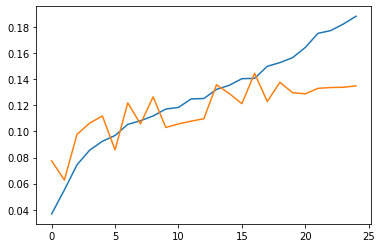

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
models[1].predict(x_test)
# model[1].evaluate(x_test)

In [ ]:
test_preds = sub.copy()
test_preds[target_cols] = 0
for model in models:
  test_preds.loc[:, target_cols] += model.predict(x_test)
test_preds.loc[:, target_cols] /= len(models)
test_preds.loc[x_test['cp_type'] == 0, target_cols] = 0
test_preds.to_csv('submission.csv', index = False)